In [1]:
"""
Necessary modules
"""
import sys, os
%load_ext autoreload
%autoreload 2 # autoreload to debug/modify modules
import numpy as np
from graphs.my_graph import * # my custom module for plots
%matplotlib inline

In [2]:
%run cortical_arousal_index/exp_data.py

## Population analysis

# Full Dataset Analysis

In [3]:
# ORDERING THE DATASET ACCORDING TO CORRELATIONS
%run cortical_arousal_index/exp_data.py
DATASET = get_one_dataset('../sparse_vs_balanced/sparse_vs_balanced/data/Wild_Type')

OUTPUT = dict(np.load('cortical_arousal_index/data/final_smooth.npz'))
mean_Output = np.mean(OUTPUT['CROSS_CORRELS'], axis=-1)
NORM = np.zeros(OUTPUT['CROSS_CORRELS'].shape)
Tsmooth = 1e3*OUTPUT['T_SMOOTH']
order = np.argsort(np.mean(OUTPUT['CROSS_CORRELS'], axis=0))
#print(OUTPUT['FILENAMES'][order]) 
iordered = np.empty(len(DATASET), dtype=np.int)
for i, cell in enumerate(DATASET):
    i0 = np.argwhere(cell['files'][0].replace('../', '../../')==OUTPUT['FILENAMES'][order])[0][0]
    iordered[i0] = i
DATASET_ORDERED = []
for i in range(len(DATASET)):
    DATASET_ORDERED.append(DATASET[iordered[i]])
    #print(DATASET_ORDERED[i]['files'][0])
DATASET = DATASET_ORDERED # OVERWRITING DATASET WITH ITS ORDER VERSION

In [4]:
#######################################################
## LOAD ALL DATASET AND STORE THE NSI OUTPUT ON DISK ##
#######################################################

DATA = []
for i in range(len(DATASET)):
    DATA.append(load_data(DATASET[i]['files'][0], args, full_processing=True))
    functions.compute_Network_State_Index(DATA[i],
                                          key='sbsmpl_Vm',
                                          target_key='Vm_NSI',
                                          p0_key='p0_Vm',
                                          Tstate=args.Tstate,
                                          Var_criteria=1000, # NOT USED, WE USE THE VALIDATION OF pLFP !!
                                          alpha=args.alpha,
                                          T_sliding_mean=args.T_sliding_mean)
    DATA[i]['cc-Vm-LFP'] = np.corrcoef(DATA[i]['sbsmpl_Vm'], DATA[i]['sbsmpl_Extra'])[0,1]
    DATA[i]['cc-Vm-pLFP'] = np.corrcoef(DATA[i]['sbsmpl_Vm'], DATA[i]['pLFP'])[0,1]

In [5]:
# storing a dictionary with the NSI data and its parameters
CELLS = {'Ncell':len(DATASET)}
dd = dict(vars(args))
for key, val in dd.items():
    CELLS[key] = val
min_NSI, max_NSI, max_time_shift, dt_shift = 0, 0, 0, 1.
for i in range(len(DATASET)):
    CELLS['cell'+str(i+1)] = {'validated_t':DATA[i]['sbsmpl_t'][DATA[i]['NSI_validated']],\
                              'validated_NSI':DATA[i]['NSI'][DATA[i]['NSI_validated']]}
    min_NSI = min([CELLS['cell'+str(i+1)]['validated_NSI'].min(), min_NSI])    
    max_NSI = max([CELLS['cell'+str(i+1)]['validated_NSI'].max(), max_NSI])    
    max_time_shift = max([DATA[i]['t'][-1]-DATA[i]['t'][0], max_time_shift])    
    dt_shift = min([np.diff(CELLS['cell'+str(i+1)]['validated_t']).min(), dt_shift]) # the time bin is the minimum interval (Tstate in methods)
for key, val in zip(['min_NSI', 'max_NSI', 'max_time_shift', 'dt_shift'], [min_NSI, max_NSI, max_time_shift, dt_shift]):
    CELLS[key] = val

np.savez('cortical_arousal_index/data/final_validated_NSI.npz', **CELLS)    

In [6]:
# loading those data
CELLS = dict(np.load('cortical_arousal_index/data/final_validated_NSI.npz'))

In [9]:
#######################################################################################
####### building the time-dependent histogram of state transitions ####################
#######################################################################################

max_time_shift, dt_shift = CELLS['max_time_shift'], CELLS['dt_shift']
NSI_Bin_Edges = np.arange(19)*2-14 #np.linspace(-20, 20, NSI_DISCRETISATION)
NSI0, DNSI = NSI_Bin_Edges[0], NSI_Bin_Edges[1]-NSI_Bin_Edges[0]
time_shifts_edges0 = np.logspace(np.log10(dt_shift), np.log10(max_time_shift), 20)
time_shifts_edges = np.concatenate([-time_shifts_edges0[::-1], time_shifts_edges0])
time_shifts = 0.5*(time_shifts_edges[1:]+time_shifts_edges[:-1])
time_shifts = 0.5*(time_shifts_edges[1:]+time_shifts_edges[:-1])
NSI_Bin = .5*(NSI_Bin_Edges[1:]+NSI_Bin_Edges[:-1])
Time_Lagged_Joint_Histogram = np.zeros((len(NSI_Bin),len(NSI_Bin), len(time_shifts), CELLS['Ncell']))
NSI_at_t, NSI_at_t_T = np.meshgrid(NSI_Bin, NSI_Bin)

subsample = 500
verbose = False

for c in range(CELLS['Ncell']):
    print('analyzing cell ', c+1, '[...]')
    t, NSI = CELLS['cell'+str(c+1)].item()['validated_t'], CELLS['cell'+str(c+1)].item()['validated_NSI']
    t0 = t[0]
    
    if subsample is not None:
        cond = np.sort(np.random.choice(np.arange(len(t)), subsample))
        t, NSI = t[cond], NSI[cond]

    Time_Lagged_Joint_Histogram[np.arange(len(NSI_Bin)), np.arange(len(NSI_Bin)),\
                                int(len(time_shifts)/2), c] += np.histogram(NSI, bins=NSI_Bin_Edges)[0]
    time=0
    for i in range(len(t)):
        # if ((t[i]-time)>60.) and verbose:
        #     time+=60
        #     print('- %imin (%i%%) ' % (int(time/60.), 100.*round(t[i]/t[-1],2)), end="", flush=True)
        for j in range(len(t)):
            shift = np.argmin((t[j]-t[i]-time_shifts)**2) # (t[j]-t[i]+max_time_shift)/dt_shift
            preS = np.argmin((NSI[i]-NSI_Bin)**2) # int((NSI[i]-NSI0)/DNSI)
            postS = np.argmin((NSI[j]-NSI_Bin)**2) # int((NSI[j]-NSI0)/DNSI)
            Time_Lagged_Joint_Histogram[preS, postS, shift, c] += 1
            Time_Lagged_Joint_Histogram[postS, preS, 2*int(len(time_shifts)/2)-shift, c] += 1
    print('') # to have a new cell

np.savez('cortical_arousal_index/data/Time_Lagged_Joint_Histogram.npz',
         **{'NSI_at_t':NSI_at_t,
            'NSI_at_t_T':NSI_at_t_T,
            'time_shifts':time_shifts,
            'time_shifts_edges':time_shifts_edges,
            'Time_Lagged_Joint_Histogram':Time_Lagged_Joint_Histogram})


analyzing cell  1 [...]



analyzing cell  2 [...]



analyzing cell  3 [...]



analyzing cell  4 [...]



analyzing cell  5 [...]



analyzing cell  6 [...]



analyzing cell  7 [...]



analyzing cell  8 [...]



analyzing cell  9 [...]



analyzing cell  10 [...]



analyzing cell  11 [...]



analyzing cell  12 [...]



analyzing cell  13 [...]



analyzing cell  14 [...]


In [1]:
data = dict(np.load('cortical_arousal_index/data/Time_Lagged_Joint_Histogram.npz'))

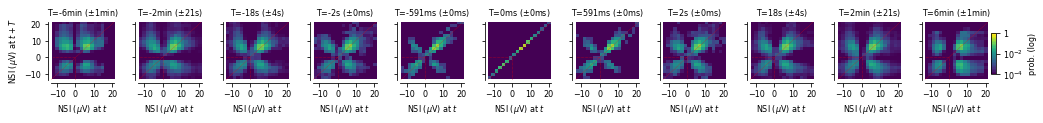

In [21]:
from graphs.surface_plots import twoD_plot
from graphs.my_graph import * 

def format_time(T, DT=0):
    
    if int(abs(T)/3600.)>0:
        unit, factor = 'h', 1/3600.
    elif int(abs(T)/60.)>0:
        unit, factor = 'min', 1/60.
    elif abs(T)<1:
        unit, factor = 'ms', 1e3
    else:
        unit, factor = 's', 1.
        
    return "%.0f"%(T*factor)+unit

    
def plot_T_dep_projec_of_joint_hist(data,
                                    lags=None,
                                    min_proba=1e-4,
                                    colormap=viridis):
    """

    """

    if lags is None:
        lags = data['time_shifts']

    fig, AX = figure(axes=(1,len(lags)), top=10., figsize=(.8,1.))
    NSI_Bin = np.unique(data['NSI_at_t'])
        
    for lag, ax in zip(lags, AX):

        ilag = np.argmin((data['time_shifts']-lag)**2)
        
        norm = data['Time_Lagged_Joint_Histogram'][:,:,ilag, :].sum()
        occur_fraction = np.log10(data['Time_Lagged_Joint_Histogram'][:,:,ilag, :].sum(axis=2)/norm+min_proba)

        ax, acb = twoD_plot(data['NSI_at_t'].flatten(), data['NSI_at_t_T'].flatten(),
                            occur_fraction.flatten(),
                            colormap=colormap,
                            ax=ax,
                            vmin=np.log10(min_proba), vmax=0.,
                            bar_legend=None)
    
        ax.plot(NSI_Bin, NSI_Bin, 'r:', lw=0.5)
        ax.plot([0,0,NSI_Bin[0]], [NSI_Bin[0],0, 0], 'r:', lw=0.5)
        ax.set_title('T='+format_time(data['time_shifts'][ilag])+" ($\pm$"+\
                     format_time(round(np.diff(data['time_shifts_edges'])[ilag]/2))+")")
        
        if ax==AX[0]:
            set_plot(ax, xlabel='NSI ($\mu$V) at $t$', ylabel='NSI ($\mu$V) at $t+T$')
        else:
            set_plot(ax, xlabel='NSI ($\mu$V) at $t$', ylabel='', yticks_labels=[])

    # then build a bar legend for the proba
    X = np.arange(-2, 1)*2        
    bar_legend(X,
               AX[-1],
               inset_rect=[1.05, .1, .08,.7],
               colormap=colormap,
               label='prob. (log)',
               ticks_labels=['$10^{'+str(i)+'}$' for i in X[:-1]]+['1'],
               bounds=[np.log10(min_proba), 0],
               color_discretization=30)
            
    return fig

lags = np.array([-351.,  -90.,
                 -20.,
                 -2.12139409,
                 -0.59148238,    0.        ,    0.59148238,
                 2.12139409,  20.,  90.,    351.])
fig = plot_T_dep_projec_of_joint_hist(data, lags=lags)


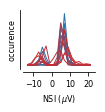

In [17]:
colormap = get_linear_colormap(Blue, Red)
NSI_Bin = np.unique(data['NSI_at_t'])
fig, ax = plot(NSI_Bin, Y=data['Time_Lagged_Joint_Histogram'][np.arange(len(NSI_Bin)), np.arange(len(NSI_Bin)),\
                                                         int(len(data['time_shifts'])/2), :].T, colormap=colormap)
set_plot(ax, yticks=[], ylabel='occurence', xlabel='NSI ($\mu$V)')

In [22]:
fig.savefig(desktop+'transitions2.svg')